<a href="https://colab.research.google.com/github/pimentoliver/fungal-futures/blob/main/PT2_Fine_Tuning_SD_LambdaLabs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part Two: Fine-tuning a stable diffusion model, exploring results**

Working from [this tutorial](https://github.com/LambdaLabsML/examples/tree/main/stable-diffusion-finetuning) by Justin Pinkney and LambdaLabsML with relevant modifications.

If you replicate this notebook: this will not work on a dataset >100MB.

Apologies for the long scrolling if you view this on GitHub. Cell output hidden in Colab version.

In [ ]:
#Check our GPU out
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-9818f0ed-02ce-3176-1694-af06ae9d7ce7)


In [ ]:
!nvidia-smi

Mon Mar 27 08:07:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Installs, cloning etc

!git clone https://github.com/justinpinkney/stable-diffusion.git
%cd stable-diffusion
!pip install --upgrade pip
!pip install -r requirements.txt

#Part of requirements, not needed in Colab
!pip uninstall -y torchtext

#Avoiding a weird bug in einops by force reinstalling the most recent version
!pip install --upgrade --force-reinstall git+https://github.com/arogozhnikov/einops.git

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 1747, done.
remote: Total 1747 (delta 0), reused 0 (delta 0), pack-reused 1747
Receiving objects: 100% (1747/1747), 73.93 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (1079/1079), done.
/content/stable-diffusion
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 23))
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-trans

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pimentooliver___parquet/pimentooliver--fungi-69b39316f314fb95/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


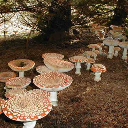

berkeley's grisette fungi


In [ ]:
#Load the dataset we made in the previous notebook
from datasets import load_dataset
ds = load_dataset("pimentooliver/fungi", split="train")

#Pull a sample to check
sample = ds[0]
display(sample["image"])
print(sample["text"])


In [ ]:
#Login to HuggingFace in order to download model weights
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()
     


Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#Fetch model weights
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)
     

In [ ]:
#Using accumulate batches to compensate for single-GPU processing or other low memory restraints
#Total batch size = batch_size * n_gpus * accumulate_batches

BATCH_SIZE = 1
N_GPUS = 1
ACCUMULATE_BATCHES = 8

### **File edits**

### Modifying and renaming the original .yaml file to fit new dataset
#### As per original tutorial, we don't have a validation dataset
#### We're just validating with some prompts, randomly selected from the ones we generated in the previous notebook.

```
data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 4
    num_workers: 4
    num_val_workers: 0 # Avoid a weird val dataloader issue
    train:
      target: ldm.data.simple.hf_dataset
      params:
        name: pimentooliver/fungi
        image_transforms:
        - target: torchvision.transforms.Resize
          params:
            size: 256
            interpolation: 3
        - target: torchvision.transforms.RandomHorizontalFlip
    validation:
      target: ldm.data.simple.TextOnly
      params:
        captions:
        - 'soapy chanterelle fungus growing in summer'
        - 'swamp agaric fungus growing on a log'
        - 'old bolete mushroom mushroom closeup'
        - 'honey crab fungus'
        output_size: 256
        n_gpus: 2 # small hack to sure we see all our samples
```



#### Modifying main.py line 861-863 to remove some string formatting not needed for single GPU processing



```
'#if not cpu:
            #ngpu = len(lightning_config.trainer.gpus.strip(",").split(','))
        if not cpu:
            ngpu = 1'
```




# **Training**

In [ ]:
#Training script

!(python main.py \
    -t \
    --base configs/stable-diffusion/sd_finetune_newyaml.yaml \
    --gpus 1 \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
    data.params.validation.params.n_gpus="$N_GPUS" \
)
     

Streaming output truncated to the last 5000 lines.
DDIM Sampler:  40% 80/199 [00:06<00:08, 13.39it/s]
DDIM Sampler:  41% 82/199 [00:06<00:08, 13.39it/s]
DDIM Sampler:  42% 84/199 [00:06<00:08, 13.38it/s]
DDIM Sampler:  43% 86/199 [00:06<00:08, 13.40it/s]
DDIM Sampler:  44% 88/199 [00:06<00:08, 13.41it/s]
DDIM Sampler:  45% 90/199 [00:06<00:08, 13.39it/s]
DDIM Sampler:  46% 92/199 [00:06<00:07, 13.42it/s]
DDIM Sampler:  47% 94/199 [00:07<00:07, 13.42it/s]
DDIM Sampler:  48% 96/199 [00:07<00:07, 13.39it/s]
DDIM Sampler:  49% 98/199 [00:07<00:07, 13.41it/s]
DDIM Sampler:  50% 100/199 [00:07<00:07, 13.41it/s]
DDIM Sampler:  51% 102/199 [00:07<00:07, 13.42it/s]
DDIM Sampler:  52% 104/199 [00:07<00:07, 13.35it/s]
DDIM Sampler:  53% 106/199 [00:07<00:06, 13.34it/s]
DDIM Sampler:  54% 108/199 [00:08<00:06, 13.32it/s]
DDIM Sampler:  55% 110/199 [00:08<00:06, 13.32it/s]
DDIM Sampler:  56% 112/199 [00:08<00:06, 13.36it/s]
DDIM Sampler:  57% 114/199 [00:08<00:06, 13.35it/s]
DDIM Sampler:  58% 116/

In [ ]:
#Running some extra scripts to fit our needs

#Our CKPT has double weights as it is holding the original weights, and fine tuned weights
#This script will cut back to the appropriate size of approx 7gb

!( python scripts/prune-ckpt.py '/content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last.ckpt')

prunin' in path: /content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last.ckpt
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers'])
removing optimizer states for path /content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last.ckpt
This is global step 10709.
saving pruned checkpoint at: /content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last-pruned.ckpt
New ckpt size: 7.70 GB. Saved 6.88 GB by removing optimizer states
done.


In [ ]:
#Pushing the model to HuggingFace for use with Stable Dreamfusion later

!(python scripts/convert_and_push_to_hub.py \
    --checkpoint_path '/content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last-pruned.ckpt' \
    --config_path '/content/stable-diffusion/configs/stable-diffusion/sd_finetune_newyaml.yaml' \
    --repo_path 'pimentooliver/fungi-sd-diffusion' \
    --output_path 'stable-diffusion/outputs' )

Cloning https://huggingface.co/pimentooliver/fungi-sd-diffusion into local empty directory.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'logit_scale', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', '

In [ ]:
#Now let's have some fun! Generating images of each fungi name, and extra prompts, to save for workflow logs later.

!(python scripts/txt2img.py \
    --prompt 'berkleys grisette fungi' \
    --outdir 'outputs/generated_fungi' \
    --H 256 --W 256 \
    --n_samples 4 \
    --config '/content/stable-diffusion/configs/stable-diffusion/sd_finetune_newyaml.yaml' \
    --ckpt '/content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last-pruned.ckpt')

Global seed set to 42
Loading model from /content/stable-diffusion/logs/2023-03-27T08-53-30_sd_finetune_newyaml/checkpoints/last-pruned.ckpt
Global Step: 10709
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vis